# Project: A CNN that Removes Lipstick from Images of Women

## Goal: Teach a CNN to Reproduce Images of Caucasian Women while Simultaneously Removing their Lipstick

In this project, I used the [VMU dataset](http://www.antitza.com/makeup-datasets.html) that contains images of caucasian women from the [FRGC dataset](https://www.nist.gov/programs-projects/face-recognition-grand-challenge-frgc) with the corresponding images of the same women with software-generated makeup application. 

The VMU dataset is very limited in size (it only contains 51 subjects), which are not enough to train a convolutional neural network. My solution to this problem was to use a large number of female faces to train a convolutional autoencoder to generally reproduce faces, and then use this trained autoencoder as a starting point and re-train it with pairs of "with makeup" and "without makeup" images (using the VMU dataset). This reduces the need for data since the weights of the autoencoder that reproduces the exact same faces are very similar to the ones that reproduce the same face without lipstick. As shown in the end the network performs really well on the test set. The images appear a little blurry and contain a few off-colored pixels but this should be expected given the large size of the images (150x130 pixels) that include three color channels and the limited size of our training set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat
import tensorflow as tf

import math

We read data from three datasets. The data from all three datasets was used to train the autoencoder. Only data from the VMU dataset was used for the lipstick removal.

In [2]:
# Read datasets
VMU = loadmat('Makeup_VMU.mat')
YMU = loadmat('Makeup_YMU.mat')
MIW = loadmat('Makeup_MIW.mat')

In [3]:
# reshape all input
def reshape_input(matrix):
    num_img = matrix.shape[1]
    VMU_test = np.reshape(matrix[:,0],(150,130,3),order="F")
    new_matrix = np.zeros((num_img,150,130,3),dtype=np.uint8) # it is important to set it uint8 for imshow to work
    for i in range(num_img):
        new_matrix[i] = np.reshape(matrix[:,i],(150,130,3),order="F")
    return new_matrix
    
X = np.concatenate((reshape_input(VMU['VMU_matrix']), reshape_input(YMU['YMU_matrix']), 
                    reshape_input(MIW['MIW_matrix'])), axis=0)

Total number of images: 1015 of size: (150, 130, 3)


[]

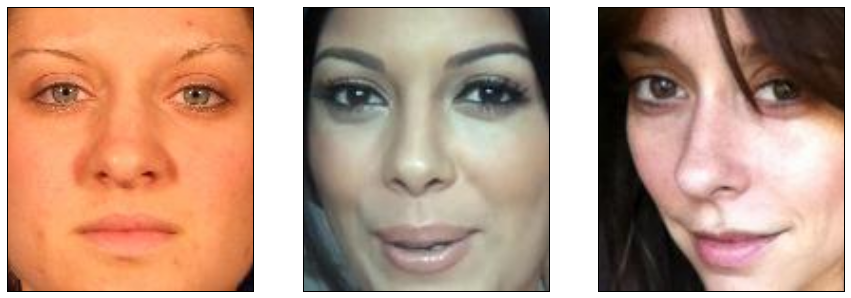

In [4]:
print "Total number of images:", X.shape[0], "of size:", X.shape[1:]
# show first and last image
f, axarr = plt.subplots(1, 3, figsize=(15,40))

axarr[0].imshow(X[0])
axarr[1].imshow(X[500])
axarr[2].imshow(X[-1])
# Hide x and y ticks
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[1].set_xticks([])
axarr[1].set_yticks([])
axarr[2].set_xticks([])
axarr[2].set_yticks([])


The total number of images from all three datasets is 1,015. Each image has a size of 150x130 pixels with 3 color channels. The images are already centered and cut. The image on the left is an example from the VMU dataset, the image on the center is from the YMU dataset and the image on the right is from the MIW dataset. The latter dataset contains images of women from different angles. This required a more complex model to train the autoencoder but it made it more generalizable to different potential datasets.

Next, we transformed the pixel values to be between -0.5 and 0.5 to use them as input to our neural network and check if the transformation back to the real values gives the expected result.

In [5]:
# transform pixel values to make them between -0.5 and 0.5
pixel_depth = 255.0  # Number of levels per pixel.
X = (X.astype(float) - pixel_depth / 2) / pixel_depth

[]

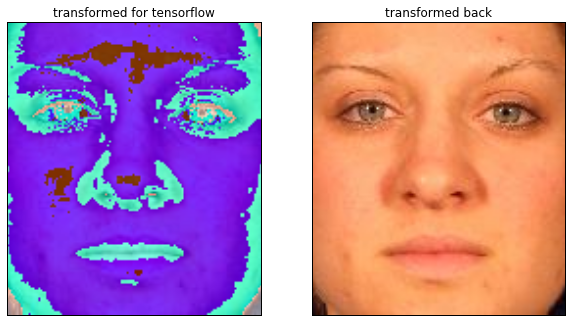

In [6]:
# see if transform them back gives correct result
f, axarr = plt.subplots(1, 2, figsize=(10,40))

axarr[0].imshow(X[0])
axarr[0].set_title('transformed for tensorflow')
axarr[1].imshow((X[0]*pixel_depth + pixel_depth / 2).astype(np.uint8))
axarr[1].set_title('transformed back')
# Hide x and y ticks
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[1].set_xticks([])
axarr[1].set_yticks([])

Below, we identified the images with the software-generated makeup application and printed the first 10 "with makeup" and "without makeup" pairs. The left column will be used as input dataset and the right column will be used as a label.

In [7]:
# Identify data for which makeup/no-makeup pairs are available
# all files with makeup applications
indices = []
for i,iname in enumerate(VMU['VMU_filenames'][0]):
    if iname[0][-7:] == '_mu.jpg':
        indices += [i]
        
print 'number of images with makeup:',len(indices)

number of images with makeup: 51


(48, 150, 130, 3) (3, 150, 130, 3)


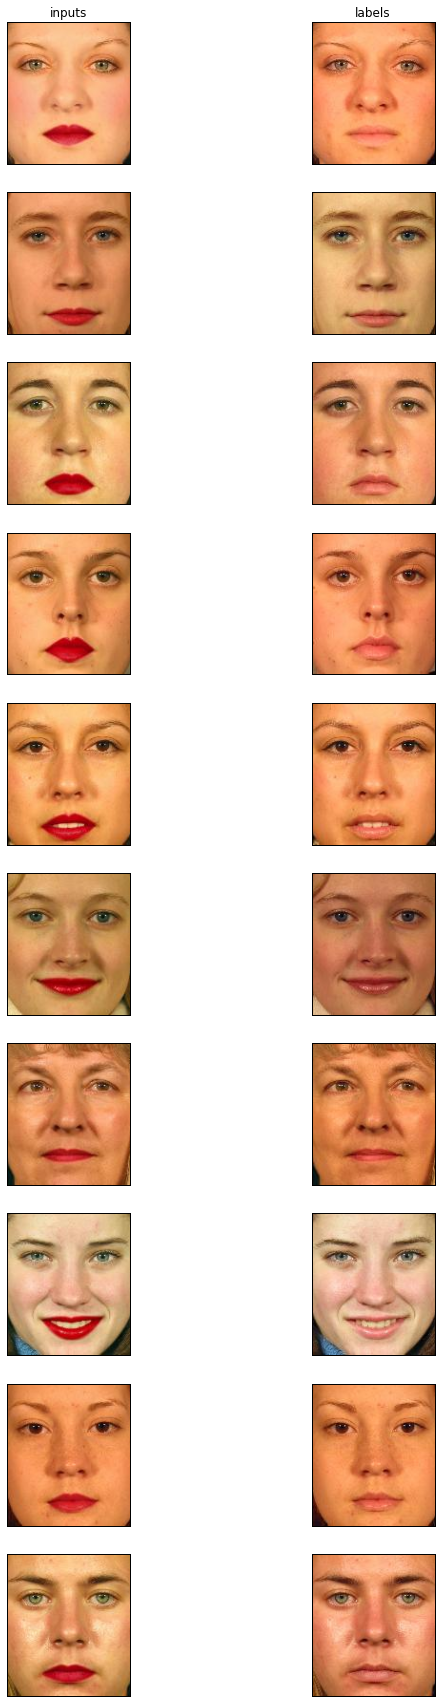

In [8]:
# Create labeled dataset of lipstick (X) and no lipstick (Y)
X_train = X[np.array(indices[:-3])-1]
Y_train = X[np.array(indices[:-3])-3]

X_test = X[np.array(indices[-3:])-1]
Y_test = X[np.array(indices[-3:])-3]

print X_train.shape, X_test.shape

# Image 48 was mislabeled
if X_train.shape[0] > 48:
    Y_train[48] = X[indices[48]+1]
else:
    Y_test[48-X_train.shape[0]] = X[indices[48]+1]

numofimg = 10
f, axarr = plt.subplots(numofimg, 2, figsize=(10,30))
for i in range(numofimg):
    axarr[i,0].imshow((X_train[i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[i,1].imshow((Y_train[i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[0,0].set_title('inputs')
    axarr[0,1].set_title('labels')
    # Hide x and y ticks
    axarr[i,0].set_xticks([])
    axarr[i,0].set_yticks([])
    axarr[i,1].set_xticks([])
    axarr[i,1].set_yticks([])

As we see in the images above, some pairs have different skin color between the two columns. This is an effect from the software that applied the lipstick on these images. To take better advantage of the autoencoder training, we transformed the results on the right to make the skin color more similar between the two.

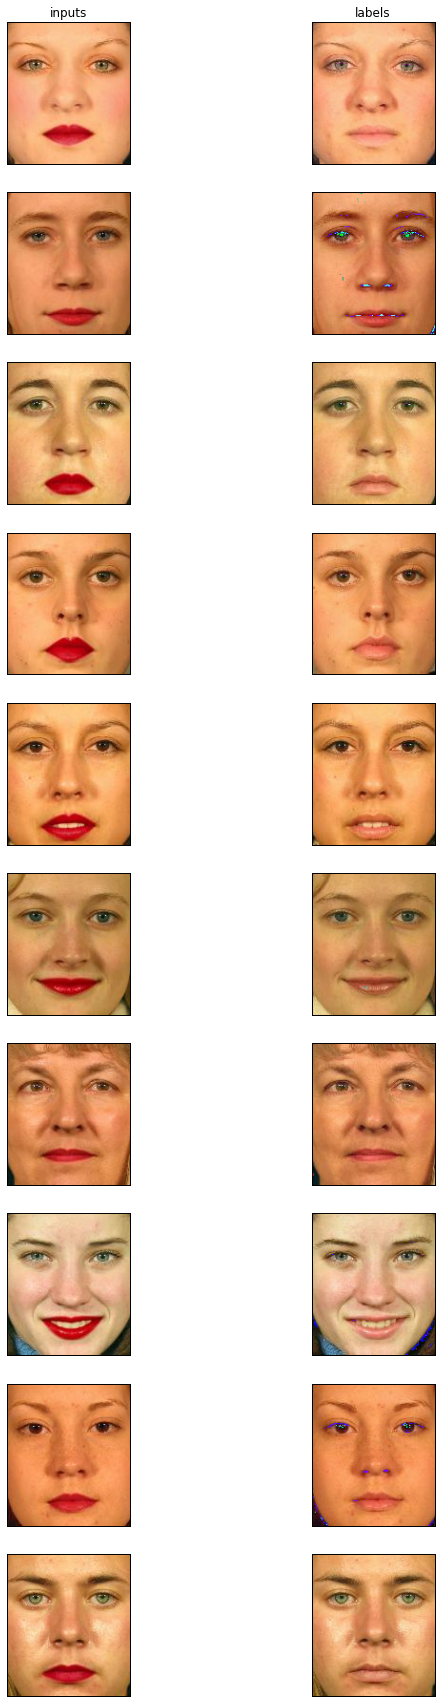

In [9]:
# Adjust color
for i in range(X_train.shape[0]):
    correction = np.mean(X_train[i,75] - Y_train[i,75],axis=0)
    for j in range(3):
        Y_train[i,:,:,j] += correction[j]
    
for i in range(X_test.shape[0]):
    correction = np.mean(X_test[i,75] - Y_test[i,75],axis=0)
    for j in range(3):
        Y_test[i,:,:,j] += correction[j]
    
numofimg = 10
f, axarr = plt.subplots(numofimg, 2, figsize=(10,30))
for i in range(numofimg):
    axarr[i,0].imshow((X_train[i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[i,1].imshow((Y_train[i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[0,0].set_title('inputs')
    axarr[0,1].set_title('labels')
    # Hide x and y ticks
    axarr[i,0].set_xticks([])
    axarr[i,0].set_yticks([])
    axarr[i,1].set_xticks([])
    axarr[i,1].set_yticks([])

As we see above the skin color is more similar between the two images now. Unfortunately, this transformation created a problem in the color of the pixels of some images (particularly in the eyes and nostrils that have very dark color values). We accepted this imperfection as most images still appear clean and we expect the neural network to average the results of the training set and reduce this error.

Next, we defined the leaky rectifier function and our convolutional autoencoder. The original functions came from a [tensorflow example](https://github.com/pkmital/tensorflow_tutorials/blob/master/python/09_convolutional_autoencoder.py). This network contains 6 convolutional layers and a leaky relu function applied on each layer. 3 of the layers are used for encoding and 3 for decoding.

In [10]:
# From tensorflow libs.activations
def lrelu(x, leak=0.2, name="lrelu"):
    """Leaky rectifier.
    Parameters
    ----------
    x : Tensor
        The tensor to apply the nonlinearity to.
    leak : float, optional
        Leakage parameter.
    name : str, optional
        Variable scope to use.
    Returns
    -------
    x : Tensor
        Output of the nonlinearity.
    """
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)


In [11]:
# Code from tensorflow example of convolutional autoencoder with slight modifications
def autoencoder(input_shape=[None, X.shape[1], X.shape[2], X.shape[3]],
                n_filters=[1, 10, 10, 10],
                filter_sizes=[3, 3, 3, 3]):
    """Build a deep denoising autoencoder w/ tied weights.
    Parameters
    ----------
    input_shape : list, optional
        Description
    n_filters : list, optional
        Description
    filter_sizes : list, optional
        Description
    Returns
    -------
    x : Tensor
        Input placeholder to the network
    z : Tensor
        Inner-most latent representation
    y : Tensor
        Output reconstruction of the input
    cost : Tensor
        Overall cost to use for training
    Raises
    ------
    ValueError
        Description
    """
    # %%
    # input to the network
    x = tf.placeholder(
        tf.float32, input_shape, name='x')
    x_label = tf.placeholder(
        tf.float32, input_shape, name='x_label')

    current_input = x

    # %%
    # Build the encoder
    encoder = []
    shapes = []
    for layer_i, n_output in enumerate(n_filters[1:]):
        n_input = current_input.get_shape().as_list()[3]
        shapes.append(current_input.get_shape().as_list())
        W = tf.Variable(
            tf.random_uniform([
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input, n_output],
                -1.0 / math.sqrt(n_input),
                1.0 / math.sqrt(n_input)))
        b = tf.Variable(tf.zeros([n_output]))
        encoder.append(W)
        output = lrelu(
            tf.add(tf.nn.conv2d(
                current_input, W, strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # %%
    # store the latent representation
    z = current_input
    encoder.reverse()
    shapes.reverse()

    # %%
    # Build the decoder using the same weights
    for layer_i, shape in enumerate(shapes):
        W = encoder[layer_i]
        b = tf.Variable(tf.zeros([W.get_shape().as_list()[2]]))
        output = lrelu(tf.add(
            tf.nn.conv2d_transpose(
                current_input, W,
                tf.stack([tf.shape(x)[0], shape[1], shape[2], shape[3]]),
                strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # %%f
    # now have the reconstruction through the network
    y = current_input
    # cost function measures pixel-wise difference
    cost = tf.reduce_sum(tf.square(y - x_label))

    # %%
    return {'x': x, 'z': z, 'y': y, 'x_label': x_label, 'cost': cost}


We trained our autoencoder (after a little experimentation with the hyperparameters) using 3x3 filters and 120 filters per layer. The first 10 images of the training set after 200 epochs of training are shown below.

0 441.973
1 284.959
2 218.903
3 180.665
4 159.715
5 139.018
6 123.519
7 112.849
8 103.463
9 97.6149
10 91.0706
11 91.7983
12 83.1477
13 76.6627
14 73.9248
15 70.0959
16 68.5984
17 62.8363
18 61.6302
19 62.1632
20 57.7678
21 51.3151
22 51.9945
23 57.4696
24 60.1153
25 42.7547
26 41.1051
27 41.2942
28 48.1585
29 41.5991
30 35.9221
31 35.106
32 33.557
33 39.0614
34 30.7337
35 42.2411
36 31.2672
37 30.5434
38 30.599
39 31.2013
40 30.5369
41 28.3216
42 36.9965
43 25.6196
44 24.9477
45 26.4595
46 25.706
47 32.0207
48 24.9978
49 23.7848
50 27.8379
51 22.5438
52 28.9492
53 22.7818
54 21.5477
55 28.0968
56 22.7063
57 36.3616
58 19.955
59 36.2803
60 18.8925
61 29.5504
62 21.1509
63 24.4263
64 20.0811
65 18.6641
66 25.0467
67 23.9389
68 18.1335
69 22.3251
70 21.9939
71 16.5305
72 17.2904
73 17.1703
74 16.2186
75 25.6297
76 17.8535
77 19.0523
78 17.1696
79 61.6105
80 29.2741
81 22.2611
82 22.7963
83 21.845
84 22.3661
85 19.8799
86 19.2971
87 19.9566
88 18.8112
89 19.8871
90 17.3918
91 17.2138
92 1

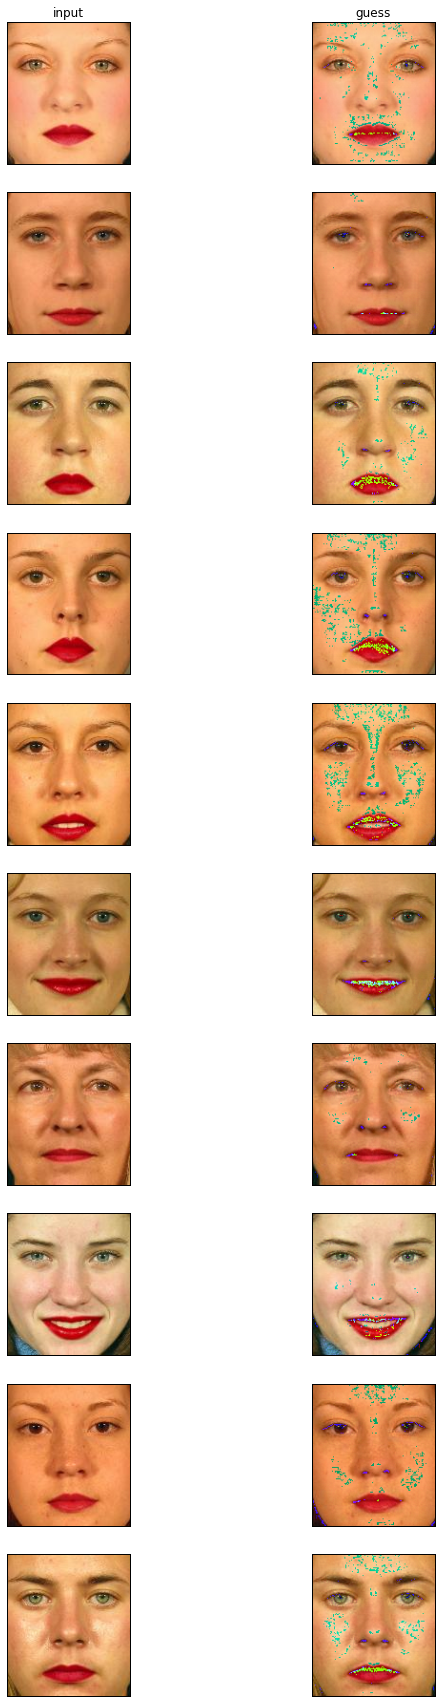

In [12]:
# Fit autoencoder data

ae = autoencoder(n_filters=[1, 120, 120, 120],filter_sizes=[3, 3, 3, 3])

# %%
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'])


# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())


# %%
# Fit all training data for autoencoder
batch_size = 2
n_epochs = 200
for epoch_i in range(n_epochs):
    for batch_i in range(X.shape[0] // batch_size):
        batch_xs = X[batch_i*batch_size:batch_i*batch_size + batch_size]
        sess.run(optimizer, feed_dict={ae['x']: batch_xs, ae['x_label']: batch_xs})
    print epoch_i, sess.run(ae['cost'], feed_dict={ae['x']: batch_xs, ae['x_label']: batch_xs})
    

# %%
# Plot example reconstructions
n_examples = 10
test_xs = X_train[:n_examples]
recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs})
print recon.shape


f, axarr = plt.subplots(n_examples, 2, figsize=(10,30))
axarr[0,0].set_title('input')
axarr[0,1].set_title('guess')
for example_i in range(n_examples):
    axarr[example_i,0].imshow((X_train[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[example_i,1].imshow((recon[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    
    # Hide x and y ticks
    axarr[example_i,0].set_xticks([])
    axarr[example_i,0].set_yticks([])
    axarr[example_i,1].set_xticks([])
    axarr[example_i,1].set_yticks([])

As we see above the autoencoder does a good job at reproducing the faces of the left column. The results are shown in the middle column. Most output images contain pixels of apparently-false colors. I believe that this is a consequence of using a very limited dataset for the size of our images and it could be fixed with the use of a more complex model and a larger training set of faces.

Next, we continued training the model defined above by using the "with makeup" and "without makeup" image pairs from the VMU dataset. The training set only contains 48 pairs of images and we trained our network for 50 epochs.

0 542.589
1 435.225
2 384.206
3 344.408
4 335.331
5 325.156
6 316.792
7 311.561
8 307.938
9 305.24
10 303.135
11 301.486
12 300.115
13 298.932
14 297.836
15 296.862
16 295.939
17 295.039
18 294.416
19 293.435
20 292.832
21 292.006
22 291.403
23 290.623
24 289.986
25 289.335
26 288.715
27 288.088
28 287.493
29 287.055
30 286.378
31 285.984
32 285.373
33 285.048
34 284.379
35 283.945
36 283.297
37 283.0
38 282.564
39 281.984
40 281.511
41 281.019
42 280.451
43 279.884
44 279.525
45 279.094
46 278.637
47 278.168
48 277.87
49 277.255
(10, 150, 130, 3)


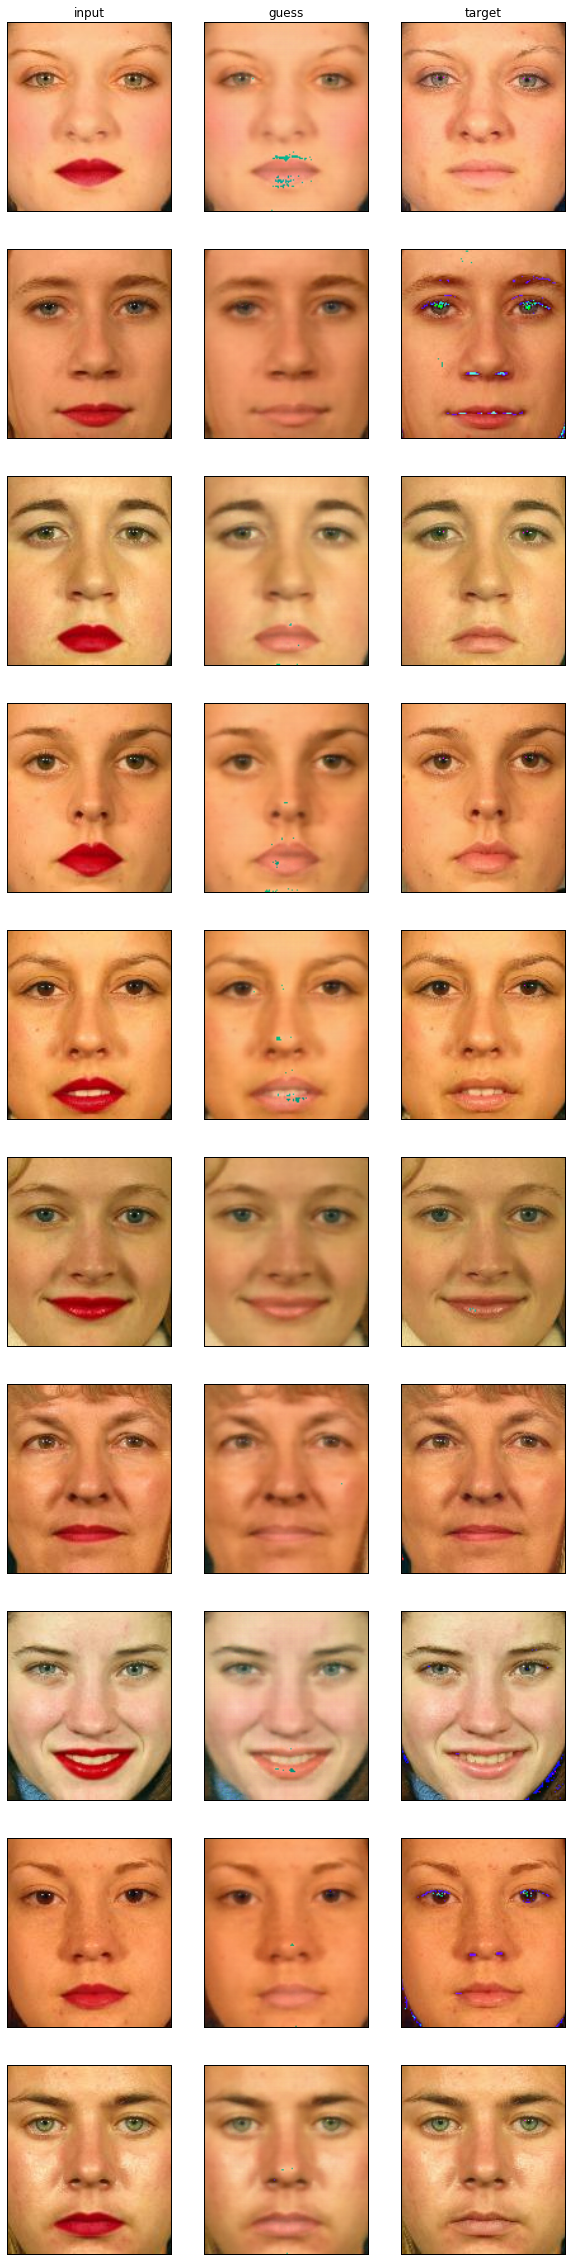

In [13]:
# Fit lipstick data in the same session
n_epochs = 50
for epoch_i in range(n_epochs):
    for batch_i in range(X_train.shape[0] // batch_size):
        batch_xs = X_train[batch_i*batch_size:batch_i*batch_size + batch_size]
        batch_xlabel = Y_train[batch_i*batch_size:batch_i*batch_size + batch_size]
        sess.run(optimizer, feed_dict={ae['x']: batch_xs, ae['x_label']: batch_xlabel})
    print epoch_i, sess.run(ae['cost'], feed_dict={ae['x']: batch_xs, ae['x_label']: batch_xlabel})
    
# %%
# Plot example reconstructions
n_examples = 10
test_xs = X_train[:n_examples]
recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs})
print recon.shape


f, axarr = plt.subplots(n_examples, 3, figsize=(10,40))
axarr[0,0].set_title('input')
axarr[0,1].set_title('guess')
axarr[0,2].set_title('target')
for example_i in range(n_examples):
    axarr[example_i,0].imshow((X_train[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[example_i,1].imshow((recon[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[example_i,2].imshow((Y_train[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    
    # Hide x and y ticks
    axarr[example_i,0].set_xticks([])
    axarr[example_i,0].set_yticks([])
    axarr[example_i,1].set_xticks([])
    axarr[example_i,1].set_yticks([])
    axarr[example_i,2].set_xticks([])
    axarr[example_i,2].set_yticks([])

The training set looks good. Even though the output images (middle column) are more blurry than the results of our autoencoder earlier, it seems that the number of off-pixels is also reduced (which is probably a product of averaging). Next, we checked how our model performed on the test set and the results seem similar to the ones above.

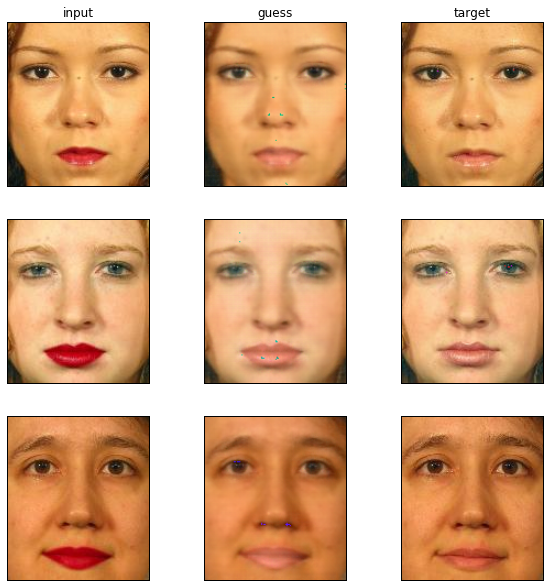

In [14]:
# print test set
recon = sess.run(ae['y'], feed_dict={ae['x']: X_test})

n_examples = X_test.shape[0]

f, axarr = plt.subplots(n_examples, 3, figsize=(10,10))
axarr[0,0].set_title('input')
axarr[0,1].set_title('guess')
axarr[0,2].set_title('target')
for example_i in range(n_examples):
    axarr[example_i,0].imshow((X_test[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[example_i,1].imshow((recon[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[example_i,2].imshow((Y_test[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    
    # Hide x and y ticks
    axarr[example_i,0].set_xticks([])
    axarr[example_i,0].set_yticks([])
    axarr[example_i,1].set_xticks([])
    axarr[example_i,1].set_yticks([])
    axarr[example_i,2].set_xticks([])
    axarr[example_i,2].set_yticks([])

Finally we tested our model with unseen data and it seems to perform better on Caucasian women that wear red lipstick. This was expected as these are limitations implemented from the training data.

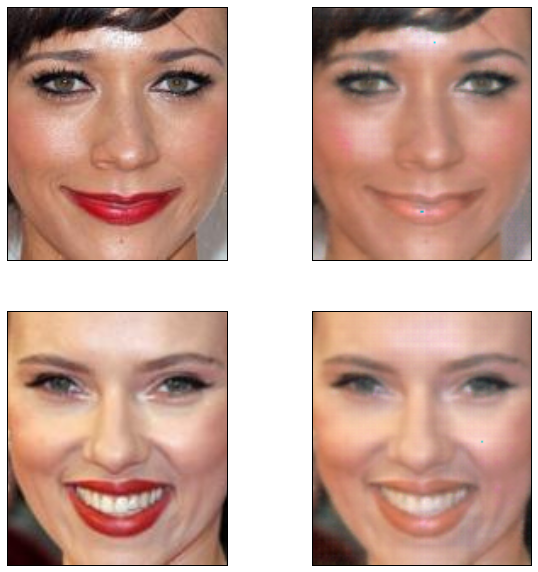

In [20]:
# Try on unseen dataset (used for autoencoding)
recon = sess.run(ae['y'], feed_dict={ae['x']: X[[-17,-15]]})

f, axarr = plt.subplots(2, 2, figsize=(10,10))

for i,example_i in enumerate([-17,-15]):
    axarr[i,0].imshow((X[example_i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    axarr[i,1].imshow((recon[i]*pixel_depth + pixel_depth / 2).astype(np.uint8))
    
    # Hide x and y ticks
    axarr[i,0].set_xticks([])
    axarr[i,0].set_yticks([])
    axarr[i,1].set_xticks([])
    axarr[i,1].set_yticks([])

In [21]:
saver = tf.train.Saver()
# Save the variables to disk.
save_path = saver.save(sess, "./model0428.ckpt")
print "Model saved in file: %s" % save_path

Model saved in file: ./model0428.ckpt
